# regression decoder test (~10/6/22) (works for our data!)
this compares a fixed decoder, pca decoder, cca transformation (w/ day0 decoder), and a regression decoder on day-N data. the latter two use a day-0 data as a prior start. 

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.folder_handler import *
from src.cort_processor import *
from src.cca_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
from src.utils import *
import pickle
import scipy as sio
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import os
import copy

In [2]:
with open('/home/diya/Documents/rat-fes/data/pickles/3-meepo919__session.pkl', 'rb') as inp: #YOUR PATH HERE
    cp1 = pickle.load(inp)
    
with open('/home/diya/Documents/rat-fes/data/pickles/meepo_1010__session.pkl', 'rb') as inp: #YOUR PATH HERE
    cp2 = pickle.load(inp)

In [3]:
nada, vaffy, nada, nada = cp1.decode_angles()
print(np.average(vaffy, 1))
nada, vaffy, nada, nada = cp2.decode_angles()
print(np.average(vaffy, 1))


[0.19  0.352 0.088 0.322 0.211 0.024 0.198]
[ 0.001 -0.023 -0.017  0.044 -0.021 -0.047  0.031]


In [4]:
cc1 = CCAProcessor(cp1, cp2, limbfoot_angle=6, align=0)

should be good to align
(1573, 32)
(1573, 7)
(1573, 32)
(1573, 7)


In [6]:
transformer, wpost, ypost = cc1.apply_ridge(angle=6)

initial_scoring is : -0.1
new_scoring is: 0.11


In [7]:
cp2_x, cp2_y = cp2.stitch_and_format()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
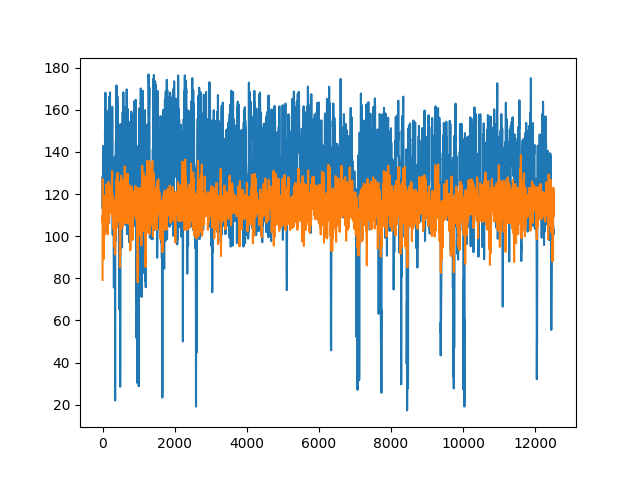

In [8]:
fig, ax = plt.subplots()
ax.plot(cp2_y[:,6])
ax.plot(ypost[:,6])

In [9]:
x_proc, y_proc = cp2.remove_bad_gaits()

In [46]:
x_proc = np.reshape(x_proc, (5310, 32))
y_proc = np.reshape(y_proc, (5310, 7))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
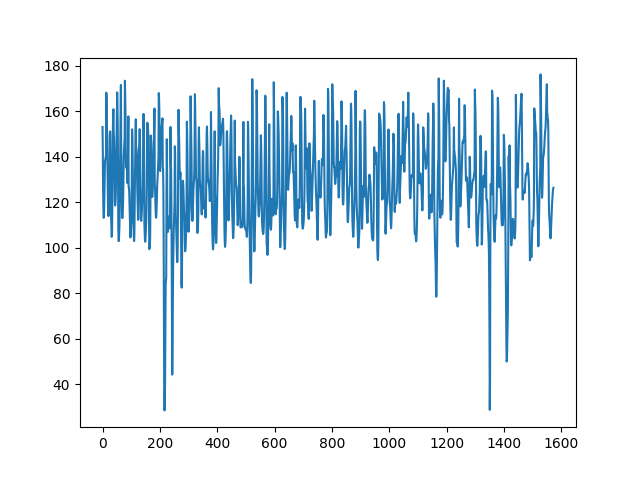

In [50]:
fig1, ax1 = plt.subplots()
ax1.plot(cc1.data['cp2']['proc_y'][:,6])

In [56]:
cca_transformer = cc1.cca

In [65]:
cca_x2 = cc1.quick_cca(x_proc, cca_transformer)

In [69]:
trans_x2 = transformer.predict(cca_x2)

In [78]:
trans_x2.shape

(5310, 32)

(5300, 7)

In [75]:
format_x, format_y = format_data(trans_x2, y_proc)

In [82]:
predic = test_wiener_filter(format_x, wpost)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
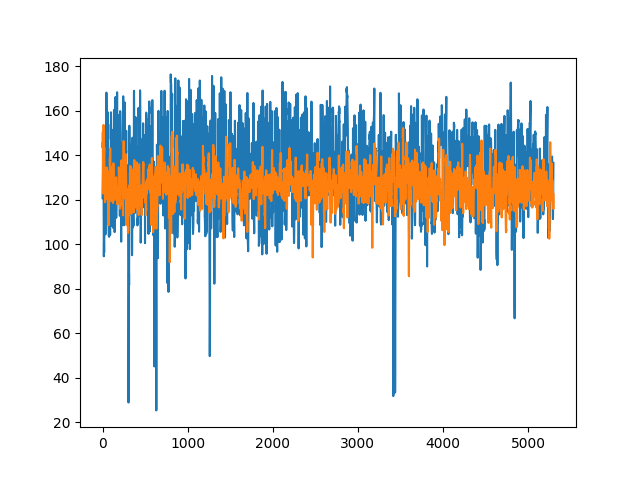

In [87]:
figgy, axxy = plt.subplots()
axxy.plot(format_y[:,6])
axxy.plot(predic[:,6]-50)

In [77]:
format_y.shape

(5300, 7)

In [39]:
ypost.shape

(12509, 7)

In [5]:
dimensions=10
#get day1 decoder weights, scaled + unscaled versions

day0_decoder, nada, naday, nadax = cp1.decode_angles(X=cp1.apply_PCA(dims=dimensions))
#lowest_num_dimensions = cp1.num_components
print(np.average(nada, 1))

X_tempy =cp1.apply_PCA(dimensions)
X_scale = cp1.apply_scaler(X=X_tempy)
day0_decoder_scale, nada, naday, nadax = cp1.decode_angles(X=X_scale)

print(np.average(nada, 1))

[0.185 0.333 0.066 0.291 0.2   0.026 0.185]
[0.189 0.338 0.069 0.295 0.207 0.028 0.191]


In [6]:
fixed_decoder_scores = []
pca_decoder_scores = []
pca_predic=[]

for i in range(len(subsample_list)):
    sub_x, sub_y = cp2.subsample(percent = subsample_list[i])
    #apply PCA just using subsampled data
    sub_x_pca = cp2.apply_PCA(dims=dimensions, X=sub_x)
    #save PCA transformation
    pca_object = cp2.pca_object
    #train PCA decoder 
    temp_h, nada, nadax, naday = cp2.decode_angles(X=sub_x_pca, Y=sub_y)
    
    test_x = cp2.apply_PCA(dims= dimensions, transformer = pca_object)
    test_y = cp2.data['angles']
    
    test_x_format, test_y_format = cp2.stitch_and_format(test_x, test_y)
    
    temp_y = test_wiener_filter(test_x_format, day0_decoder)
    fixed_decoder_scores.append(vaf(test_y_format[:,angle_num], temp_y[:,angle_num]))
    
    temp_y = test_wiener_filter(test_x_format, temp_h)
    pca_decoder_scores.append(vaf(test_y_format[:,angle_num], temp_y[:,angle_num]))
    
    pca_predic.append(temp_y)

print(fixed_decoder_scores)
print(pca_decoder_scores)

[-0.23, 0.06, -0.04, 0.21, 0.17]
[-2477.94, 0.13, 0.27, 0.3, 0.34]


In [7]:
cca_decoder_scores = []
cca_transformers=[]
for i in range(len(subsample_list)):
    #make subsampled cp2
    temp_cp2 = copy.deepcopy(cp2)
    sub_x2, sub_y2 = temp_cp2.subsample(percent = subsample_list[i])
    
    temp_cp2.data['rates'] = sub_x2
    temp_cp2.data['angles'] = sub_y2
    
    temp_cca = CCAProcessor(cp1, temp_cp2, limbfoot_angle=3)
    
    pca_sub_x1, pca_sub_x2 = temp_cca.apply_PCA(preset_num_components=dimensions)
    temp_cca_transformer, nada = temp_cca.apply_CCA(preset_num_components = dimensions, pca=True)
    
    cca_transformers.append(temp_cca_transformer)
    
    test_x = cp2.apply_PCA(dims=dimensions, transformer = temp_cca.data['cp2']['pca_transformer'])
    test_y = cp2.data['angles']
    
    transformed_test_x = []
    
    for x_recording in test_x:
        nada, test_x_cca_space = temp_cca_transformer.transform(x_recording, x_recording)
        temp_x = temp_cca_transformer.inverse_transform(test_x_cca_space)
                                                        
        transformed_test_x.append(temp_x)
        
    transformed_test_x_format, test_y_format = cp2.stitch_and_format(transformed_test_x, test_y)    
    
    predic = test_wiener_filter(transformed_test_x_format, day0_decoder)
    
    cca_decoder_scores.append(vaf(test_y_format[:,angle_num], predic[:,angle_num]))
    
print(cca_decoder_scores)

should be good to align
(40, 32)
(40, 7)
(40, 32)
(40, 7)
should be good to align
(223, 32)
(223, 7)
(223, 32)
(223, 7)
should be good to align
(488, 32)
(488, 7)
(488, 32)
(488, 7)
should be good to align
(1995, 32)
(1995, 7)
(1995, 32)
(1995, 7)
should be good to align
(3238, 32)
(3238, 7)
(3238, 32)
(3238, 7)
[0.04, -0.05, 0.03, 0.18, -0.1]


In [8]:
r_scores = []
r_predic=[]

for i in range(len(subsample_list)):
    #subsample day-n unprocessed data
    sub_x, sub_y = cp2.subsample(percent = subsample_list[i])
    
    #apply PCA to subsampled data
    sub_x_pca = cp2.apply_PCA(dims=dimensions, X=sub_x)
    #transform PCA subsample to day-0 shape
    
    transformed_sub_x_pca = []
    for x_recording in sub_x_pca:
        nada, sub_x_cca_space = cca_transformers[i].transform(x_recording, x_recording)
        temp_x = cca_transformers[i].inverse_transform(sub_x_cca_space)
        transformed_sub_x_pca.append(temp_x)
        
    #scale transformed data 
    scaled_transformed_sub_x_pca = cp2.apply_scaler(X=transformed_sub_x_pca)
    scaler = cp2.scaler
    x_format, y_format = cp2.stitch_and_format(scaled_transformed_sub_x_pca, sub_y)

    wpost, nada = ridge_fit(b0=day0_decoder_scale, x_format=x_format, y_format=y_format, my_alpha=100.0)
    
    
    ###now lets test on full dataset
    test_x = cp2.apply_PCA(dims=dimensions, transformer = cp2.pca_object)
    test_y = cp2.data['angles']
    test_x_transformed=[]
    for x_recording in test_x:
    
        nada, test_xx = temp_cca.apply_CCA(cp2_x = x_recording, transformer = cca_transformers[i], pca=True)
        test_x_transformed.append(scaler.transform(test_xx))
        
    test_x_format, test_y_format = cp2.stitch_and_format(test_x_transformed, test_y)
    
    temp_y = test_wiener_filter(test_x_format, wpost)
    
    r_predic.append(temp_y)  
    predic = vaf(test_y_format[:,angle_num], temp_y[:,angle_num])
    
 
    r_scores.append(predic)

initial_scoring is : -0.77
new_scoring is: 0.43
initial_scoring is : -0.27
new_scoring is: 0.23
initial_scoring is : -0.33
new_scoring is: 0.35
initial_scoring is : -0.08
new_scoring is: 0.33
initial_scoring is : -0.17
new_scoring is: 0.36


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
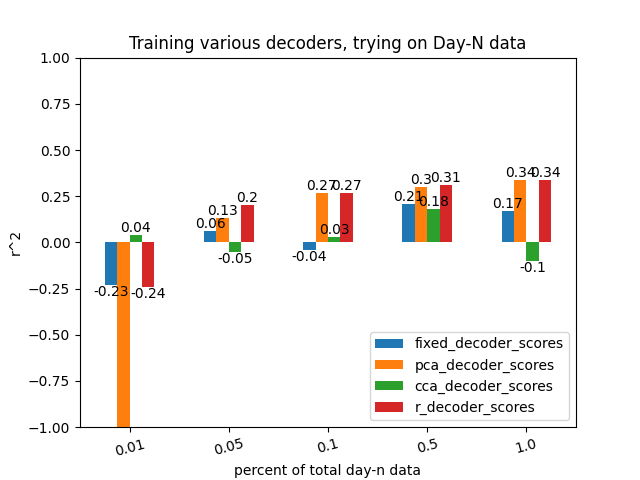

In [9]:
%matplotlib widget
%matplotlib widget

plot_dict = {}
plot_dict['fixed_decoder_scores'] = fixed_decoder_scores
plot_dict['pca_decoder_scores'] = pca_decoder_scores
plot_dict['cca_decoder_scores'] = cca_decoder_scores
plot_dict['r_decoder_scores'] = r_scores

index = subsample_list

df = pd.DataFrame(data=plot_dict, index=index)

  
# plot grouped bar chart
ax = df.plot.bar(rot=15)
ax.set_ylim(bottom=-1, top=1)
ax.set_title('Training various decoders, trying on Day-N data')
ax.set_ylabel('r^2')
ax.set_xlabel('percent of total day-n data')
ax.legend(loc='lower right')
for container in ax.containers:
    ax.bar_label(container)